In [1]:
import sys
from decimal import Decimal


import numpy as np
from nautilus_trader.core.correctness import PyCondition
from nautilus_trader.examples.strategies.ema_cross import EMACross, EMACrossConfig
from nautilus_trader.core.data import Data
from nautilus_trader.core.message import Event,Request,Response
from nautilus_trader.model.position import Position
from nautilus_trader.persistence.wranglers import BarDataWrangler, TradeTickDataWrangler
from nautilus_trader.common.factories import OrderFactory
from nautilus_trader.common.providers import InstrumentProvider,InstrumentId,Instrument
from nautilus_trader.trading import trader, Trader
from nautilus_trader.trading import strategy, Strategy
from nautilus_trader.trading.strategy import StrategyConfig
from numpy.core._string_helpers import english_lower



In [2]:
from nautilus_trader.core.correctness import PyCondition
from nautilus_trader.indicators.base.indicator import Indicator
from nautilus_trader.model.data import Bar
from nautilus_trader.model.data import QuoteTick
from nautilus_trader.model.data import TradeTick
from nautilus_trader.model.enums import PriceType

from typing import Optional, Tuple

class ema_indicator(Indicator):
    def __init__(self, period: int, price_type: PriceType = PriceType.LAST):
        PyCondition.positive_int(period, "period")
        
        super().__init__(list_params=[period])

        self.period = period
        self.price_type = price_type
        self.alpha = 2.0 / (period + 1.0)
        self.value = 0.0  # <-- stateful value
        self.count = 0  # <-- stateful value
    
    def handle_quote_tick(self, tick: QuoteTick):
        PyCondition.not_none(tick, "tick")

        self.update_raw(tick.extract_price(self.price_type).as_double())    
    
    
    def handle_trade_tick(self, tick: TradeTick):
        PyCondition.not_none(tick, "tick")

        self.update_raw(tick.price.as_double())
    
    def handle_bar(self, bar: Bar):
        pass
    
    def update_raw(self, value: float):
        # Check if this is the initial input
        if not self.has_inputs:
            self.value = value

        self.value = self.alpha * value + ((1.0 - self.alpha) * self.value)
        self.count += 1

        # Initialization logic
        if not self.initialized:
            self._set_has_inputs(True)
            if self.count >= self.period:
                self._set_initialized(True)
    
    def _reset(self):
        # Override this method to reset stateful values introduced in the class.
        # This method will be called by the base when `.reset()` is called.
        self.value = 0.0
        self.count = 0

In [3]:
class Ema_cross_config(StrategyConfig):
    instrument_id: str
    bar_type: str
    # non-essential
    allow_asia_session: bool = False
    use_fixed_trade_size = True
    fixed_trade_size: Decimal = 0.0
    # ...



In [4]:

class Ema_cross(Strategy):
    def __init__(self, config: Ema_cross_config) -> None:
        super().__init__(config)
        
        # Load Configuration
        self.instrument_id = config.instrument_id
        self.bar_type = config.bar_type
        
        if(config.allow_asia_session):
            pass
        if(config.use_fixed_trade_size):
            pass   
        # Load Indicators
        self.ema1 = ema_indicator(period=20, price_type=PriceType.MID)
        


DATA_PATH='./data'
         time     open     high      low    close  tick_volume  spread  \
0  1609718400  1.22395  1.23098  1.22280  1.22473        85620       0   
1  1609804800  1.22466  1.23056  1.22432  1.22965        75380       0   
2  1609891200  1.22968  1.23494  1.22657  1.23252       118259       0   
3  1609977600  1.23256  1.23441  1.22452  1.22710        84749       0   
4  1610064000  1.22713  1.22845  1.21932  1.22218       100138       0   

   real_volume  
0            0  
1            0  
2            0  
3            0  
4            0  
Saved EURUSD to ./data\EURUSD.csv


In [2]:
from nautilus_trader.persistence.loaders import CSVBarDataLoader
from nautilus_trader.test_kit.providers import TestInstrumentProvider
from nautilus_trader.model.data import BarType, Bar
from nautilus_trader.persistence.wranglers import BarDataWrangler



               open     high      low    close  tick_volume  spread  \
time                                                                  
2021-01-04  1.22395  1.23098  1.22280  1.22473        85620       0   
2021-01-05  1.22466  1.23056  1.22432  1.22965        75380       0   
2021-01-06  1.22968  1.23494  1.22657  1.23252       118259       0   
2021-01-07  1.23256  1.23441  1.22452  1.22710        84749       0   
2021-01-08  1.22713  1.22845  1.21932  1.22218       100138       0   

            real_volume  
time                     
2021-01-04            0  
2021-01-05            0  
2021-01-06            0  
2021-01-07            0  
2021-01-08            0  
Index(['open', 'high', 'low', 'close', 'tick_volume', 'spread', 'real_volume'], dtype='object')


[CurrencyPair(id=EURUSD.SIM, raw_symbol=EURUSD, asset_class=FX, asset_type=SPOT, quote_currency=USD, is_inverse=False, price_precision=5, price_increment=0.00001, size_precision=0, size_increment=1, multiplier=1, lot_size=1000, margin_init=0.03, margin_maint=0.03, maker_fee=0.00002, taker_fee=0.00002, info=None),
 CurrencyPair(id=EURUSD.SIM, raw_symbol=EURUSD, asset_class=FX, asset_type=SPOT, quote_currency=USD, is_inverse=False, price_precision=5, price_increment=0.00001, size_precision=0, size_increment=1, multiplier=1, lot_size=1000, margin_init=0.03, margin_maint=0.03, maker_fee=0.00002, taker_fee=0.00002, info=None)]

In [341]:
from nautilus_trader.core.datetime import dt_to_unix_nanos

start = dt_to_unix_nanos(pd.Timestamp("2022-01-01", tz="UTC"))
end =  dt_to_unix_nanos(pd.Timestamp("2023-11-23", tz="UTC"))
# Load data from catalog
eurusd = TestInstrumentProvider.default_fx_ccy("EURUSD")

bars_catalog = catalog.query(data_cls=Bar, instrument_ids=[eurusd.id.value], start=start, end=end, )


In [342]:
len(df)

755

In [343]:
len(bars_catalog)

494

In [344]:
df.head()

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2021-01-04,1.22395,1.23098,1.22280,1.22473,85620,0,0
2021-01-05,1.22466,1.23056,1.22432,1.22965,75380,0,0
2021-01-06,1.22968,1.23494,1.22657,1.23252,118259,0,0
2021-01-07,1.23256,1.23441,1.22452,1.22710,84749,0,0
2021-01-08,1.22713,1.22845,1.21932,1.22218,100138,0,0


In [345]:
bars_catalog

[Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.13693,1.13778,1.12795,1.12971,53813,1641168000000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.12961,1.13226,1.12723,1.12862,62525,1641254400000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.12852,1.13466,1.12765,1.13135,61289,1641340800000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.13111,1.13316,1.12846,1.12976,67251,1641427200000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.12960,1.13647,1.12901,1.13590,49836,1641513600000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.13550,1.13599,1.12853,1.13252,53457,1641772800000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.13230,1.13753,1.13131,1.13666,49386,1641859200000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.13655,1.14528,1.13545,1.14411,51872,1641945600000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.14402,1.14817,1.14357,1.14539,53078,1642032000000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.14531,1.14829,1.13987,1.14151,59882,1642118400000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.14

In [346]:
catalog.instruments()

[CurrencyPair(id=EURUSD.SIM, raw_symbol=EURUSD, asset_class=FX, asset_type=SPOT, quote_currency=USD, is_inverse=False, price_precision=5, price_increment=0.00001, size_precision=0, size_increment=1, multiplier=1, lot_size=1000, margin_init=0.03, margin_maint=0.03, maker_fee=0.00002, taker_fee=0.00002, info=None),
 CurrencyPair(id=EURUSD.SIM, raw_symbol=EURUSD, asset_class=FX, asset_type=SPOT, quote_currency=USD, is_inverse=False, price_precision=5, price_increment=0.00001, size_precision=0, size_increment=1, multiplier=1, lot_size=1000, margin_init=0.03, margin_maint=0.03, maker_fee=0.00002, taker_fee=0.00002, info=None)]

In [347]:
from nautilus_trader.config import BacktestVenueConfig

venue_configs = [
    BacktestVenueConfig(
        name="SIM",
        oms_type="HEDGING",
        account_type="MARGIN",
        base_currency="USD",
        starting_balances=["10000 USD"],
    ),
]

In [348]:
from nautilus_trader.config import BacktestDataConfig

data_configs = [
    BacktestDataConfig(
        catalog_path=str(catalog.path),
        data_cls=Bar,
        instrument_id=eurusd.id.value,
        start_time=start,
        end_time=end,
    ),
]
data_configs

[BacktestDataConfig(catalog_path='C:/Users/puche/code/nautilus/catalog', data_cls=<class 'nautilus_trader.model.data.bar.Bar'>, catalog_fs_protocol=None, catalog_fs_storage_options=None, instrument_id='EURUSD.SIM', start_time=1640995200000000000, end_time=1700697600000000000, filter_expr=None, client_id=None, metadata=None, bar_spec=None, batch_size=10000)]

In [350]:
from nautilus_trader.trading.strategy import ImportableStrategyConfig

from decimal import Decimal

strategies = [
    ImportableStrategyConfig(
        strategy_path="nautilus_trader.examples.strategies.ema_cross:EMACross",
        config_path="nautilus_trader.examples.strategies.ema_cross:EMACrossConfig",
        config=dict(
            instrument_id=eurusd.id.value,
            bar_type=f"{eurusd.id.value}-1-DAY-LAST-EXTERNAL",
            fast_ema_period=10,
            slow_ema_period=20,
            trade_size=Decimal(100_000),
        ),
    ),
]
strategies

[ImportableStrategyConfig(strategy_path='nautilus_trader.examples.strategies.ema_cross:EMACross', config_path='nautilus_trader.examples.strategies.ema_cross:EMACrossConfig', config={'instrument_id': 'EURUSD.SIM', 'bar_type': 'EURUSD.SIM-1-DAY-LAST-EXTERNAL', 'fast_ema_period': 10, 'slow_ema_period': 20, 'trade_size': Decimal('100000')})]

In [17]:
from nautilus_trader.config import BacktestRunConfig, BacktestEngineConfig

configs = [BacktestRunConfig(
    engine=BacktestEngineConfig(strategies=strategies),
    data=data_configs,
    venues=venue_configs,
)]

In [18]:
from nautilus_trader.backtest.node import BacktestNode

node = BacktestNode(configs)

In [19]:
res = node.run()

In [20]:
res

[BacktestResult(trader_id='BACKTESTER-001', machine_id='DESKTOP-3FSERNM', run_config_id='4eb6d9b442956ae2829bda9860d723b5b146d3be3c885755e0ec9c3f8520a238', instance_id='66267bc4-4b9a-4792-bcb7-43f3485a6bb4', run_id='13e2f4df-70be-45aa-a6fd-f4aee465ec37', run_started=1700844194275320300, run_finished=1700844194473766900, backtest_start=1641168000000000000, backtest_end=1700611200000000000, elapsed_time=59443200.0, iterations=0, total_events=84, total_orders=28, total_positions=14, stats_pnls={'USD': {'PnL (total)': 12875.15, 'PnL% (total)': 128.75150000000002, 'Max Winner': 7736.45, 'Avg Winner': 3168.082857142857, 'Min Winner': 825.01, 'Min Loser': -81.03, 'Avg Loser': -1328.7757142857142, 'Max Loser': -3051.08, 'Expectancy': 919.6535714285714, 'Win Rate': 0.5}}, stats_returns={'Returns Volatility (252 days)': 0.06718573987135841, 'Average (Return)': 0.00896299123059925, 'Average Loss (Return)': -0.012154466055280169, 'Average Win (Return)': 0.030080448516478668, 'Sharpe Ratio (252 day

In [21]:
res[0]

BacktestResult(trader_id='BACKTESTER-001', machine_id='DESKTOP-3FSERNM', run_config_id='4eb6d9b442956ae2829bda9860d723b5b146d3be3c885755e0ec9c3f8520a238', instance_id='66267bc4-4b9a-4792-bcb7-43f3485a6bb4', run_id='13e2f4df-70be-45aa-a6fd-f4aee465ec37', run_started=1700844194275320300, run_finished=1700844194473766900, backtest_start=1641168000000000000, backtest_end=1700611200000000000, elapsed_time=59443200.0, iterations=0, total_events=84, total_orders=28, total_positions=14, stats_pnls={'USD': {'PnL (total)': 12875.15, 'PnL% (total)': 128.75150000000002, 'Max Winner': 7736.45, 'Avg Winner': 3168.082857142857, 'Min Winner': 825.01, 'Min Loser': -81.03, 'Avg Loser': -1328.7757142857142, 'Max Loser': -3051.08, 'Expectancy': 919.6535714285714, 'Win Rate': 0.5}}, stats_returns={'Returns Volatility (252 days)': 0.06718573987135841, 'Average (Return)': 0.00896299123059925, 'Average Loss (Return)': -0.012154466055280169, 'Average Win (Return)': 0.030080448516478668, 'Sharpe Ratio (252 days

In [22]:
# pairs tradin: src, tgt
# src = catalog.bars(instrument_ids=[..], start=pd.Timestamp(), end=..., as_nautilus=True)

# Merge into single dataframe for convenience, filter for market hours only
# df = bars_to_dataframe(source_id=, source_bars=, target_id=, target_bars= )
# df.index = pd.to_datetime(df.index)
# df = df.between_time(datetime.time(14,30), datetime.time(21,0))

# view scatter plot of src vs tgt
# df.pct_change().cumsum().hvplot.step(y=[src_id, tgt_id], title=f"timeseries of ...")

# FIT A MODEL
# Format values for scikit learn
# X = df.loc[:, src_id].astype(float).values.reshape(-1, 1)
# Y = df.loc[:, tgt_id].astype(float).values.reshape(-1, 1)

# Fit a model
# from sklearn.linearmodel import LinearRegression
# from sklearn.metrics import r2_score
# model = LinearRegresseion(fit_intercept=False)
# model.fit(X, Y)

# hedge_ratio = float(model.coef_[0][0])
# use slope to calculate the shares for each stock to keep us dollar flat
#df.loc[:, "predicted"] = df.loc[:, src_id] * hedge_ratio
#df.loc[:, "spread"]= df["predicted"] - df[tgt_id]

# ts_plot= df.hvplot.step(y=[tgt_id, 'predicted])
# spread_plot= df["spread"].hvplot() * hv.HLine(0).opts(color="r", line_width=1)
#(ts_plot + spread_plot).cols(1)


In [23]:
# Visualize run
node.configs[0]

BacktestRunConfig(venues=[BacktestVenueConfig(name='SIM', oms_type='HEDGING', account_type='MARGIN', starting_balances=['10000 USD'], base_currency='USD', default_leverage=1.0, leverages=None, book_type='L1_MBP', routing=False, frozen_account=False, bar_execution=True, reject_stop_orders=True, support_gtd_orders=True, support_contingent_orders=True, use_position_ids=True, use_random_ids=False, use_reduce_only=True, modules=None)], data=[BacktestDataConfig(catalog_path='C:/Users/puche/code/nautilus/catalog', data_cls=<class 'nautilus_trader.model.data.bar.Bar'>, catalog_fs_protocol=None, catalog_fs_storage_options=None, instrument_id='EURUSD.SIM', start_time=1640995200000000000, end_time=1700697600000000000, filter_expr=None, client_id=None, metadata=None, bar_spec=None, batch_size=10000)], engine=BacktestEngineConfig(environment=<Environment.BACKTEST: 'backtest'>, trader_id='BACKTESTER-001', instance_id=None, cache=None, cache_database=None, data_engine=DataEngineConfig(time_bars_build

In [24]:
engine = node.get_engines()[0]

In [25]:

print(engine.list_venues())
print(engine.trader_id)

[Venue('SIM')]
BACKTESTER-001


In [26]:
bt = res[0]

In [27]:

bt.run_id

'13e2f4df-70be-45aa-a6fd-f4aee465ec37'

In [28]:
from nautilus_trader.trading.trader import Trader,Portfolio

In [29]:
t: Trader = engine.trader
t.strategies()

[EMACross(EMACross-000)]

In [30]:
t.actors()

[]

In [31]:
t.generate_orders_report()

,trader_id,strategy_id,instrument_id,venue_order_id,position_id,account_id,last_trade_id,type,side,quantity,...,contingency_type,order_list_id,linked_order_ids,parent_order_id,exec_algorithm_id,exec_algorithm_params,exec_spawn_id,tags,ts_init,ts_last
client_order_id,,,,,,,,,,,,,,,,,,,,,
O-20220128-0000-001-000-1,BACKTESTER-001,EMACross-000,EURUSD.SIM,SIM-1-001,SIM-1-001,SIM-001,SIM-1-022,MARKET,SELL,100000,...,NO_CONTINGENCY,None,None,None,None,None,None,None,1643328000000000000,1643328000000000000
O-20220204-0000-001-000-2,BACKTESTER-001,EMACross-000,EURUSD.SIM,SIM-1-002,SIM-1-001,SIM-001,SIM-1-029,MARKET,BUY,100000,...,NO_CONTINGENCY,None,None,None,None,None,None,None,1643932800000000000,1643932800000000000
O-20220204-0000-001-000-3,BACKTESTER-001,EMACross-000,EURUSD.SIM,SIM-1-003,SIM-1-002,SIM-001,SIM-1-031,MARKET,BUY,100000,...,NO_CONTINGENCY,None,None,None,None,None,None,None,1643932800000000000,1643932800000000000
O-20220222-0000-001-000-4,BACKTESTER-001,EMACross-000,EURUSD.SIM,SIM-1-004,SIM-1-002,SIM-001,SIM-1-045,MARKET,SELL,100000,...,NO_CONTINGENCY,None,None,None,None,None,None,None,1645488000000000000,1645488000000000000
O-20220222-0000-001-000-5,BACKTESTER-001,EMACross-000,EURUSD.SIM,SIM-1-005,SIM-1-003,SIM-001,SIM-1-047,MARKET,SELL,100000,...,NO_CONTINGENCY,None,None,None,None,None,None,None,1645488000000000000,1645488000000000000
O-20220526-0000-001-000-6,BACKTESTER-001,EMACross-000,EURUSD.SIM,SIM-1-006,SIM-1-003,SIM-001,SIM-1-116,MARKET,BUY,100000,...,NO_CONTINGENCY,None,None,None,None,None,None,None,1653523200000000000,1653523200000000000
O-20220526-0000-001-000-7,BACKTESTER-001,EMACross-000,EURUSD.SIM,SIM-1-007,SIM-1-004,SIM-001,SIM-1-118,MARKET,BUY,100000,...,NO_CONTINGENCY,None,None,None,None,None,None,None,1653523200000000000,1653523200000000000
O-20220610-0000-001-000-8,BACKTESTER-001,EMACross-000,EURUSD.SIM,SIM-1-008,SIM-1-004,SIM-001,SIM-1-131,MARKET,SELL,100000,...,NO_CONTINGENCY,None,None,None,None,None,None,None,1654819200000000000,1654819200000000000
O-20220610-0000-001-000-9,BACKTESTER-001,EMACross-000,EURUSD.SIM,SIM-1-009,SIM-1-005,SIM-001,SIM-1-133,MARKET,SELL,100000,...,NO_CONTINGENCY,None,None,None,None,None,None,None,1654819200000000000,1654819200000000000


In [32]:
positions = t._cache.positions() + t._cache.position_snapshots()
positions


[Position(FLAT EURUSD.SIM, id=SIM-1-001),
 Position(FLAT EURUSD.SIM, id=SIM-1-002),
 Position(FLAT EURUSD.SIM, id=SIM-1-003),
 Position(FLAT EURUSD.SIM, id=SIM-1-004),
 Position(FLAT EURUSD.SIM, id=SIM-1-005),
 Position(FLAT EURUSD.SIM, id=SIM-1-006),
 Position(FLAT EURUSD.SIM, id=SIM-1-007),
 Position(FLAT EURUSD.SIM, id=SIM-1-008),
 Position(FLAT EURUSD.SIM, id=SIM-1-009),
 Position(FLAT EURUSD.SIM, id=SIM-1-010),
 Position(FLAT EURUSD.SIM, id=SIM-1-011),
 Position(FLAT EURUSD.SIM, id=SIM-1-012),
 Position(FLAT EURUSD.SIM, id=SIM-1-013),
 Position(FLAT EURUSD.SIM, id=SIM-1-014)]

In [33]:
t.generate_account_report(engine.list_venues()[0]).columns


Index(['total', 'locked', 'free', 'currency', 'account_id', 'account_type',
       'base_currency', 'margins', 'reported', 'info'],
      dtype='object')

In [34]:
# plot this strategies orders and positions in matplotlib plot

import matplotlib.pyplot as plt



In [35]:
from nautilus_trader.model.identifiers import Venue
from nautilus_trader.portfolio import Portfolio
portfolio : Portfolio = engine.portfolio
v : Venue = engine.list_venues()[0]

In [36]:

from nautilus_trader.accounting.accounts.margin import MarginAccount

acc : MarginAccount = portfolio.account(v)

In [37]:
acc.balance()
acc.margins()

{}

In [38]:
from nautilus_trader.portfolio.base import PortfolioFacade
from nautilus_trader.analysis.analyzer import PortfolioAnalyzer
analyzer : PortfolioAnalyzer = portfolio.analyzer 

In [39]:
analyzer._positions

[Position(FLAT EURUSD.SIM, id=SIM-1-001),
 Position(FLAT EURUSD.SIM, id=SIM-1-002),
 Position(FLAT EURUSD.SIM, id=SIM-1-003),
 Position(FLAT EURUSD.SIM, id=SIM-1-004),
 Position(FLAT EURUSD.SIM, id=SIM-1-005),
 Position(FLAT EURUSD.SIM, id=SIM-1-006),
 Position(FLAT EURUSD.SIM, id=SIM-1-007),
 Position(FLAT EURUSD.SIM, id=SIM-1-008),
 Position(FLAT EURUSD.SIM, id=SIM-1-009),
 Position(FLAT EURUSD.SIM, id=SIM-1-010),
 Position(FLAT EURUSD.SIM, id=SIM-1-011),
 Position(FLAT EURUSD.SIM, id=SIM-1-012),
 Position(FLAT EURUSD.SIM, id=SIM-1-013),
 Position(FLAT EURUSD.SIM, id=SIM-1-014)]

In [40]:
analyzer._statistics

{'Max Winner': <nautilus_trader.analysis.statistics.winner_max.MaxWinner at 0x26715223400>,
 'Avg Winner': <nautilus_trader.analysis.statistics.winner_avg.AvgWinner at 0x267153ca050>,
 'Min Winner': <nautilus_trader.analysis.statistics.winner_min.MinWinner at 0x267153ca0e0>,
 'Min Loser': <nautilus_trader.analysis.statistics.loser_min.MinLoser at 0x267153ca110>,
 'Avg Loser': <nautilus_trader.analysis.statistics.loser_avg.AvgLoser at 0x267153ca140>,
 'Max Loser': <nautilus_trader.analysis.statistics.loser_max.MaxLoser at 0x267153ca170>,
 'Expectancy': <nautilus_trader.analysis.statistics.expectancy.Expectancy at 0x267153ca080>,
 'Win Rate': <nautilus_trader.analysis.statistics.win_rate.WinRate at 0x267153ca0b0>,
 'Returns Volatility (252 days)': <nautilus_trader.analysis.statistics.returns_volatility.ReturnsVolatility at 0x267153ca1a0>,
 'Average (Return)': <nautilus_trader.analysis.statistics.returns_avg.ReturnsAverage at 0x267153ca200>,
 'Average Loss (Return)': <nautilus_trader.anal

In [41]:
from nautilus_trader.analysis.statistics import winner_max

In [42]:
res[0]

BacktestResult(trader_id='BACKTESTER-001', machine_id='DESKTOP-3FSERNM', run_config_id='4eb6d9b442956ae2829bda9860d723b5b146d3be3c885755e0ec9c3f8520a238', instance_id='66267bc4-4b9a-4792-bcb7-43f3485a6bb4', run_id='13e2f4df-70be-45aa-a6fd-f4aee465ec37', run_started=1700844194275320300, run_finished=1700844194473766900, backtest_start=1641168000000000000, backtest_end=1700611200000000000, elapsed_time=59443200.0, iterations=0, total_events=84, total_orders=28, total_positions=14, stats_pnls={'USD': {'PnL (total)': 12875.15, 'PnL% (total)': 128.75150000000002, 'Max Winner': 7736.45, 'Avg Winner': 3168.082857142857, 'Min Winner': 825.01, 'Min Loser': -81.03, 'Avg Loser': -1328.7757142857142, 'Max Loser': -3051.08, 'Expectancy': 919.6535714285714, 'Win Rate': 0.5}}, stats_returns={'Returns Volatility (252 days)': 0.06718573987135841, 'Average (Return)': 0.00896299123059925, 'Average Loss (Return)': -0.012154466055280169, 'Average Win (Return)': 0.030080448516478668, 'Sharpe Ratio (252 days

In [43]:
# code from bfs-nyc discord

import quantstats as qs
from nautilus_trader.portfolio import Portfolio

def calculate_daily_returns(portfolio: Portfolio):
    return portfolio.analyzer.returns().dropna().resample("1D").sum().sort_index()

PATH = os.getcwd() + "/quantstats"
if not os.path.exists(PATH):
  print(f"Creating quantstats directory at: {PATH}")
  os.mkdir(PATH)

def generate_qs_tear_sheet(returns: pd.Series, benchmark: pd.Series = None):
    qs.reports.html(returns, benchmark, output= os.path.join(PATH, "qs_tearsheet.html"))


In [44]:

generate_qs_tear_sheet(calculate_daily_returns(portfolio))

C:\Users\puche\code\nautilus\venv\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\puche\code\nautilus\venv\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\puche\code\nautilus\venv\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduct

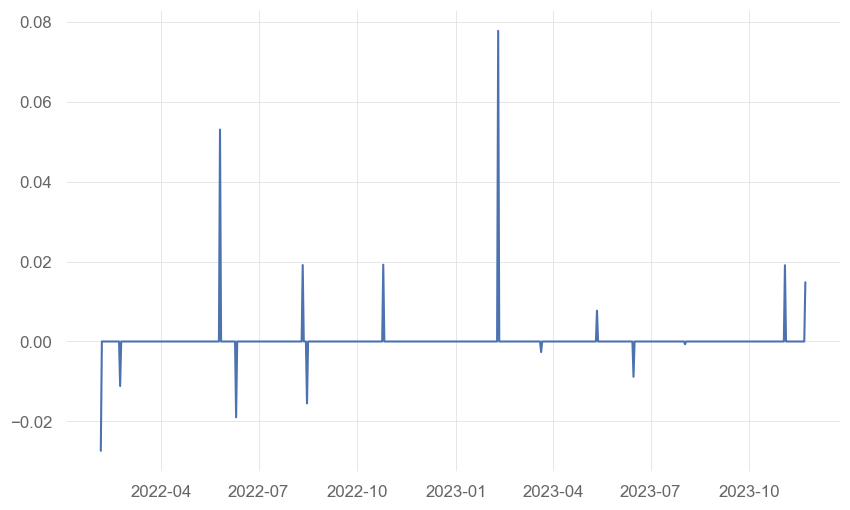

In [45]:
import matplotlib.pyplot as plt
plt.plot(calculate_daily_returns(portfolio))

In [46]:
from pandas import Series

returns: Series = portfolio.analyzer.returns()
type(returns)

pandas.core.series.Series

In [47]:
strat : EMACross = t.strategies()[0]

In [48]:
from nautilus_trader.cache.cache import Cache
cache : Cache = engine.cache

In [49]:
ins : Instrument = cache.instrument(strat.instrument_id)

In [50]:
from nautilus_trader.model.data.bar import Bar
from nautilus_trader.model.objects import Price
bars = cache.bars( bar_type )

type(bars[0].close)

closes = list(map(lambda x: (x.ts_event , x.close.as_double()), bars))


In [51]:
closes

[(1700611200000000000, 1.08882),
 (1700524800000000000, 1.09101),
 (1700438400000000000, 1.09396),
 (1700179200000000000, 1.09128),
 (1700092800000000000, 1.08513),
 (1700006400000000000, 1.08461),
 (1699920000000000000, 1.08782),
 (1699833600000000000, 1.06981),
 (1699574400000000000, 1.06845),
 (1699488000000000000, 1.06674),
 (1699401600000000000, 1.07083),
 (1699315200000000000, 1.06993),
 (1699228800000000000, 1.07168),
 (1698969600000000000, 1.07292),
 (1698883200000000000, 1.062),
 (1698796800000000000, 1.05687),
 (1698710400000000000, 1.05752),
 (1698624000000000000, 1.0614),
 (1698364800000000000, 1.0564),
 (1698278400000000000, 1.05615),
 (1698192000000000000, 1.05664),
 (1698105600000000000, 1.05886),
 (1698019200000000000, 1.06693),
 (1697760000000000000, 1.05931),
 (1697673600000000000, 1.05814),
 (1697587200000000000, 1.05354),
 (1697500800000000000, 1.05769),
 (1697414400000000000, 1.05592),
 (1697155200000000000, 1.0507),
 (1697068800000000000, 1.05272),
 (1696982400000

ts_open=(1643328000000000000,), ts_close=(1643932800000000000,), price_open=1.1146819602, price_close=1.1451475834
<class 'tuple'> <class 'tuple'> <class 'float'> <class 'float'>
ts_open_dt=DatetimeIndex(['2022-01-28'], dtype='datetime64[ns]', freq=None), ts_close_dt=DatetimeIndex(['2022-02-04'], dtype='datetime64[ns]', freq=None)
ts_open=(1643932800000000000,), ts_close=(1645488000000000000,), price_open=1.1451475834, price_close=1.1324025727
<class 'tuple'> <class 'tuple'> <class 'float'> <class 'float'>
ts_open_dt=DatetimeIndex(['2022-02-04'], dtype='datetime64[ns]', freq=None), ts_close_dt=DatetimeIndex(['2022-02-22'], dtype='datetime64[ns]', freq=None)
ts_open=(1645488000000000000,), ts_close=(1653523200000000000,), price_open=1.1324025727, price_close=1.0723978932
<class 'tuple'> <class 'tuple'> <class 'float'> <class 'float'>
ts_open_dt=DatetimeIndex(['2022-02-22'], dtype='datetime64[ns]', freq=None), ts_close_dt=DatetimeIndex(['2022-05-26'], dtype='datetime64[ns]', freq=None)
t

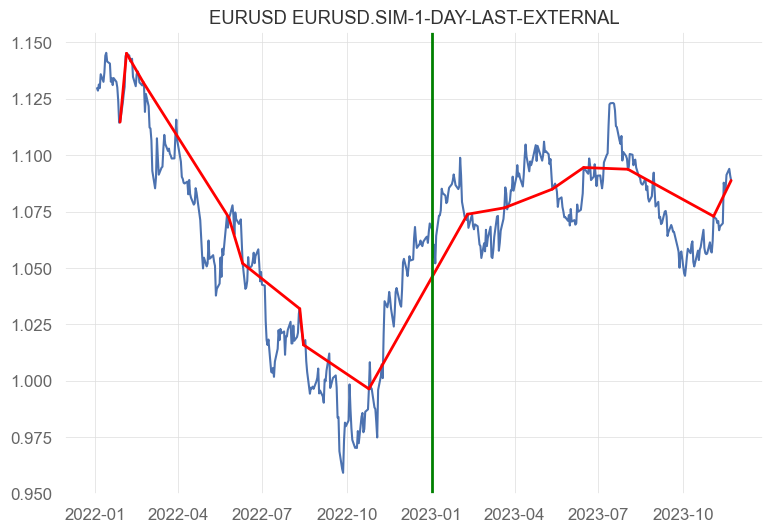

In [351]:

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
# convert closes timestamps to datetime objects
closes = list(map(lambda x: (pd.to_datetime(x[0], unit='ns'), x[1]), closes))
# why zip? https://stackoverflow.com/questions/13704860/zip-lists-in-python
ax.plot(*zip(*closes))
ax.set_title(f"{ins.symbol} {bar_type}")

# plot positions
type(positions[0])
for p in positions:
    p : Position = p
    
    if not p.instrument_id == ins.id:
        print(f"Skipping position {p.id} as it is not for {ins.symbol}")
        continue

    ts_open = p.ts_opened,
    ts_close = p.ts_closed,
    price_open = p.avg_px_open
    price_close = p.avg_px_close
    
    ts_open_dt = pd.to_datetime(ts_open, unit='ns')
    ts_close_dt = pd.to_datetime(ts_close, unit='ns')
    
    
    # debug print these values
    print(f"{ts_open=}, {ts_close=}, {price_open=}, {price_close=}")
    print(type(ts_open), type(ts_close), type(price_open), type(price_close))
    print(f"{ts_open_dt=}, {ts_close_dt=}")
    ax.plot([ts_open_dt, ts_close_dt], [price_open, price_close], color="red", linewidth=2)
    # convert the unix timestamps (nanoseconds) in the plot to datetime objects using formatter
    #ax.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d'), )
 
# add a random vertical line
dt = pd.to_datetime("2023-01-01 11:06:09")
print(dt.to_datetime64())
ax.axvline(x= dt  , color="green", linewidth=2)
    

In [ ]:
# make it more beautiful and reusable


# Let's define the first strategy using bollinger bands
# Then create the first framework building block being the strategy builder
# Then add easy to use visualization into the framework


In [ ]:
from nautilus_trader.model.data.bar import *
from nautilus_trader.model.objects import *
from nautilus_trader.model.position import *
from nautilus_trader.model.enums import *
from nautilus_trader.portfolio import *
from nautilus_trader.trading.trader import *
from nautilus_trader.trading.strategy import *
from nautilus_trader.indicators.base import indicator


In [92]:
import rustworkx
from typing import Callable

# Direction enum used to define the models predicted direction
# this is a very simple direction enum
from enum import Enum
class Direction(Enum):
    NEUTRAL = 0
    LONG = 1
    SHORT = 2


class PUT101:
    @staticmethod
    def builder():
        return PUT101._Builder()
        pass
    
    class _Builder:
        g = rustworkx.PyDiGraph()
        
        def __init__(self):
            pass
        def __repr__(self):
            return f"_Builder()"
        
        # add the node to the graph such that it can be processed
        # automatically by the framework to integrate into nautilus
        # returns the index in the graph
        def add_node(self, n) -> int:
            return self.g.add_node(n)
        
        def add_rule (self, n: int, m: int, f: Callable[[], bool]) -> None:
            self.g.add_edge(n, m, f)
            pass


class PUT101Config(StrategyConfig, frozen=True):
    instrument_id: str
    bar_type: str
    trade_size: Decimal
    fast_ema_period: int = 10
    slow_ema_period: int = 20
    emulation_trigger: str = "NO_TRIGGER"
    oms_type = "HEDGING"
    
    # PUT101 specific


In [93]:

class Node:
    def __init__(self):
        self.indicators: list[Indicator] = []
        self.index = None
        pass
    # used to register these indicators later to nautilus
    def get_indicators(self) -> list[Indicator]:
        return self.indicators


def get_direction_extremes(value, upper, lower) -> Direction:
    if value > upper:
        return Direction.SHORT
    elif value < lower:
        return Direction.LONG
    else:
        return Direction.NEUTRAL

def matching_directions(d1: Direction, d2: Direction) -> bool:
    return d1 == d2

def opposite_directions(d1: Direction, d2: Direction) -> bool:
    return d1 != d2

def is_long(d: Direction) -> bool:
    return d == Direction.LONG

def is_short(d: Direction) -> bool:
    return d == Direction.SHORT

def is_neutral(d: Direction) -> bool:
    return d == Direction.NEUTRAL

 

from nautilus_trader.indicators.rsi import RelativeStrengthIndex
# define a rsi indicator and use it to exposes methods
# that return Direction enum to build the strategy rules
class RSINode(Node):
    def __init__(self, period: int):
        super().__init__()
        assert period > 0
        
        self.period = period
        
        self.rsi = RelativeStrengthIndex(period)
        self.indicators.append(self.rsi)
        
    def __repr__(self):
        return f"RSINode({self.period})"
    
    def get_direction_extremes(self, upper, lower) -> Direction:
        return get_direction_extremes(self.rsi.value, upper, lower)
    
        

# example usage
PUT101.builder().add_node(RSINode(14))


0

In [219]:
from nautilus_trader.core.rust.common import LogColor

import pandas as pd
# define another one but inherit from the base class Indicator and pass all events onto the indicator but track the values somehow
# this is a very simple indicator

# define a wrapper indicator that tracks all values of the indicator in an efficient way using numpy that only stores the values for on_bar event 
class IndicatorValueTracker(Indicator):
    def __init__(self, indicator: Indicator, getter: Callable[[Indicator], float]):
        super().__init__([])
        self.indicator = indicator
        self.data = []
        self.getter = getter # used to get the value from the indicator
    
    def handle_bar(self, bar: Bar) -> None:
        print("handling bar in IndicatorValueTracker")
        # pass event to indicator
        self.indicator.handle_bar(bar)
        # store the value in the dataframe
        
        self.data.append((bar.ts_event, self.getter(self.indicator)))
        pass
    

class PUT101Strategy(Strategy):
    def __init__(self, config: PUT101Config) -> None:
        super().__init__(config)
        
        print("TEST")
        
        # Load Configuration
        self.instrument_id = config.instrument_id
        self.bar_type: BarType = BarType.from_str(config.bar_type)
        
        # PUT101 specific
        
        self.indicators: list[Indicator] = []
        self.nodes = None
        
        self.value_tracker = IndicatorValueTracker(indicator=RelativeStrengthIndex(14), getter= lambda x: x.value)
        
        print(self.value_tracker)
        
        self.indicators.append(self.value_tracker)
        
        # Users order management variables
        self.entry = None
        self.trailing_stop = None
        self.position_id = None
        pass
    
    
    def on_start(self) -> None:
        # Try to register the indicators
        
        self.subscribe_bars(self.bar_type)
        
        
        pass
    
    
    # MT5 bars are of course of type Bar
    def on_bar(self, bar: Bar) -> None:
        print("handling bar")
        self.log.info(
                f"test log on_bar",
                color=LogColor.BLUE,
            )
        self.value_tracker.handle_bar(bar)
        
        pass

    

In [352]:

configs = [BacktestRunConfig(
    engine=BacktestEngineConfig(strategies=[
            ImportableStrategyConfig(
                strategy_path="__main__:PUT101Strategy",
                config_path="__main__:PUT101Config",
                config=dict(
                    instrument_id=eurusd.id.value,
                    bar_type=f"{eurusd.id.value}-1-DAY-LAST-EXTERNAL",
                    trade_size=Decimal(100_000),
                ),
            ),
        
    ],),
    data=data_configs,
    venues=venue_configs,
)]

node = BacktestNode(configs)

In [353]:
res = node.run()


TEST
IndicatorValueTracker()
handling bar
handling bar in IndicatorValueTracker
handling bar
handling bar in IndicatorValueTracker
handling bar
handling bar in IndicatorValueTracker
handling bar
handling bar in IndicatorValueTracker
handling bar
handling bar in IndicatorValueTracker
handling bar
handling bar in IndicatorValueTracker
handling bar
handling bar in IndicatorValueTracker
handling bar
handling bar in IndicatorValueTracker
handling bar
handling bar in IndicatorValueTracker
handling bar
handling bar in IndicatorValueTracker
handling bar
handling bar in IndicatorValueTracker
handling bar
handling bar in IndicatorValueTracker
handling bar
handling bar in IndicatorValueTracker
handling bar
handling bar in IndicatorValueTracker
handling bar
handling bar in IndicatorValueTracker
handling bar
handling bar in IndicatorValueTracker
handling bar
handling bar in IndicatorValueTracker
handling bar
handling bar in IndicatorValueTracker
handling bar
handling bar in IndicatorValueTracker
h

In [222]:
t = node.get_engines()[0].trader

In [233]:
data =t.strategies()[0].value_tracker.data

<Axes: xlabel='timestamp'>

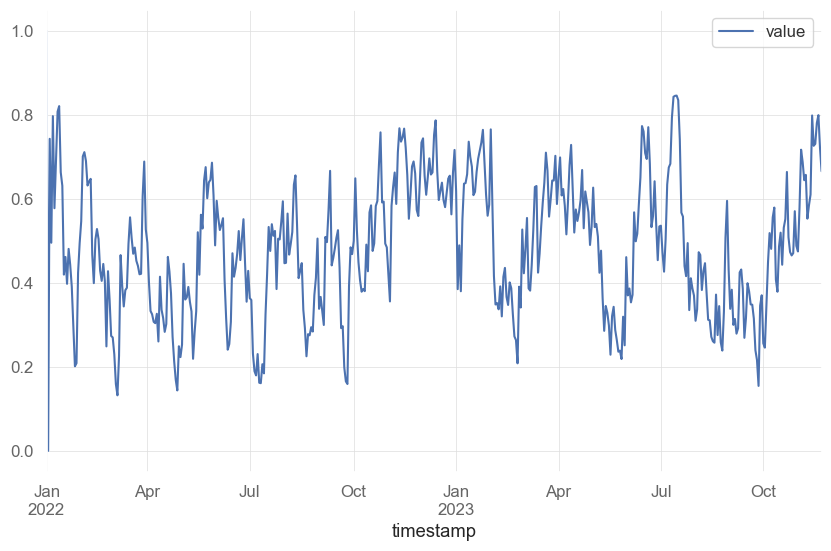

In [236]:
# data is a list of tuples (timestamp, value)
# convert to dataframe with timestamp as index
# then plot
df = pd.DataFrame(data, columns=["timestamp", "value"])
df["timestamp"] = pd.to_datetime(df["timestamp"], unit='ns')
df.set_index("timestamp", inplace=True)
df.plot()


In [274]:
from collections.abc import Mapping, Container

from sys import getsizeof

def deep_getsizeof(o, ids=None):
    """Find the memory footprint of a Python object

This is a recursive function that drills down a Python object graph

like a dictionary holding nested dictionaries with lists of lists

and tuples and sets.

The sys.getsizeof function does a shallow size of only. It counts each

object inside a container as pointer only regardless of how big it

really is.

:param o: the object

:param ids:

:return:

"""

    # for entry point
    if ids is None:
        ids = set()

    d = deep_getsizeof

    if id(o) in ids:

        return 0

    r = getsizeof(o)

    ids.add(id(o))

    if isinstance(o, str) or isinstance(0, str):

        return r

    if isinstance(o, Mapping):

        return r + sum(d(k, ids) + d(v, ids) for k, v in o.iteritems())

    if isinstance(o, Container):

        return r + sum(d(x, ids) for x in o)

    return r 


In [275]:
type(sys.getsizeof(data))

int

In [276]:
deep_getsizeof(data)

61404

In [284]:
def print_bytes(n_bytes: int, use_iec_binary=True):  
    # print the bytes in a human readable format
    # using kilo mega giga etc according to this table: https://en.wikipedia.org/wiki/Byte#Multiple-byte_units
    
    if use_iec_binary:
        units = ["B", "KiB", "MiB", "GiB", "TiB", "PiB"]
        base = 1024
    else:
        units = ["B", "KB", "MB", "GB", "TB", "PB"]
        base = 1000
    
    for unit in units:
        if n_bytes < base:
            print(f"{n_bytes:.1f} {unit}")
            return
        n_bytes /= base

In [285]:
print_bytes(deep_getsizeof(bars))

84.8 KiB


In [286]:
bars

[Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.09067,1.09227,1.08522,1.08882,52654,1700611200000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.09398,1.09649,1.09000,1.09101,49286,1700524800000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.09008,1.09517,1.08973,1.09396,45170,1700438400000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.08519,1.09137,1.08247,1.09128,49504,1700179200000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.08462,1.08953,1.08299,1.08513,54528,1700092800000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.08784,1.08855,1.08314,1.08461,73551,1700006400000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.06916,1.08872,1.06916,1.08782,79728,1699920000000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.06751,1.07060,1.06648,1.06981,47554,1699833600000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.06674,1.06926,1.06560,1.06845,52644,1699574400000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.07060,1.07253,1.06599,1.06674,53055,1699488000000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.06

In [287]:
bars

[Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.09067,1.09227,1.08522,1.08882,52654,1700611200000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.09398,1.09649,1.09000,1.09101,49286,1700524800000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.09008,1.09517,1.08973,1.09396,45170,1700438400000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.08519,1.09137,1.08247,1.09128,49504,1700179200000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.08462,1.08953,1.08299,1.08513,54528,1700092800000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.08784,1.08855,1.08314,1.08461,73551,1700006400000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.06916,1.08872,1.06916,1.08782,79728,1699920000000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.06751,1.07060,1.06648,1.06981,47554,1699833600000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.06674,1.06926,1.06560,1.06845,52644,1699574400000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.07060,1.07253,1.06599,1.06674,53055,1699488000000000000),
 Bar(EURUSD.SIM-1-DAY-LAST-EXTERNAL,1.06

In [289]:
s : PUT101Strategy= t.strategies()[0]

In [296]:
c :Cache= s.cache

In [302]:
c.bars(bar_type)

c.quote_ticks(ins.id)

[]

In [315]:
from nautilus_trader.model.identifiers import Symbol
new_ins =InstrumentId(Symbol("EURUSD"), Venue("SIM"))

In [314]:
c.quote_ticks(new_ins)

[]